# Comparison of N-qubit Entanglement Transfer Protocols (Split Gate Times)

This notebook compares three different methods for transferring entanglement from qubit `0` (entangled with `1`) to qubit `N-1`:

1.  **Feedback Teleportation**: Uses measurement and feed-forward corrections.
2.  **Post-Selection Teleportation**: Uses measurement and post-selects on the '0' outcome (no feedback).
3.  **SWAP Chain**: Physically moves the qubit state using a chain of SWAP gates.

In this version, we use **different gate times** for single-qubit (50ns) and two-qubit (500ns) gates to better reflect realistic hardware constraints where two-qubit gates are significantly slower and thus accumulate more decoherence.

In [1]:
from __future__ import annotations

import math
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Sequence

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import HGate, CZGate
from qiskit.quantum_info import DensityMatrix, partial_trace, state_fidelity, Kraus, Operator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    ReadoutError,
    amplitude_damping_error,
    depolarizing_error,
    phase_damping_error,
)

## 1. Shared Noise Model Configuration (Split Gate Times)

In [2]:
@dataclass
class NoiseParams:
    p_single: float = 1.798e-4#2e-3
    p_two: float =  1.4983-3#1e-2
    p_readout: float = 4.21e-3#1.5e-2
    t1: float = 301.15e-6
    tphi: float = 355.86e-6
    gate_time_1q: float = 3.2e-8  # 32ns for single-qubit gates
    gate_time_2q: float = 2.08e-7  # 208ns for two-qubit gates

def combined_damping_error(t1=None, tphi=None, gate_time=5e-8):
    """Return a single-qubit error channel for amplitude damping (T1) and pure dephasing (Tphi)."""
    errors = []
    if t1:
        p_amp = 1 - math.exp(-gate_time / t1)
        errors.append(amplitude_damping_error(p_amp))
    if tphi:
        p_phase = 1 - math.exp(-gate_time / tphi)
        errors.append(phase_damping_error(p_phase))

    if not errors:
        return None

    combined = errors[0]
    for err in errors[1:]:
        combined = combined.compose(err)
    return combined

def build_noise_model(params: NoiseParams) -> NoiseModel:
    """Build Qiskit Aer NoiseModel for Feedback and SWAP simulations."""
    noise_model = NoiseModel()

    single_depolar = depolarizing_error(params.p_single, 1)
    two_depolar = depolarizing_error(params.p_two, 2)
    readout_error = ReadoutError([[1 - params.p_readout, params.p_readout], [params.p_readout, 1 - params.p_readout]])

    # Separate damping for 1q vs 2q gates
    damping_1q = combined_damping_error(t1=params.t1, tphi=params.tphi, gate_time=params.gate_time_1q)
    damping_2q = combined_damping_error(t1=params.t1, tphi=params.tphi, gate_time=params.gate_time_2q)

    if damping_1q is not None:
        single_error = single_depolar.compose(damping_1q)
    else:
        single_error = single_depolar

    if damping_2q is not None:
        # For 2-qubit gate, we apply damping to both qubits
        two_error = two_depolar.compose(damping_2q.tensor(damping_2q))
    else:
        two_error = two_depolar

    single_gate_set = ["id", "x", "sx", "rz", "h"]
    two_gate_set = ["cx", "cz"] # 'swap' excluded to force decomposition

    noise_model.add_all_qubit_quantum_error(single_error, single_gate_set)
    noise_model.add_all_qubit_quantum_error(two_error, two_gate_set)
    noise_model.add_all_qubit_readout_error(readout_error)
    return noise_model

def get_noise_channels(params: NoiseParams):
    """Get discrete channels for manual Post-Selection simulation."""
    single_depolar = depolarizing_error(params.p_single, 1)
    
    # Use 1q gate time
    damping_1q = combined_damping_error(t1=params.t1, tphi=params.tphi, gate_time=params.gate_time_1q)
    if damping_1q:
        single_error = single_depolar.compose(damping_1q)
    else:
        single_error = single_depolar
        
    two_depolar = depolarizing_error(params.p_two, 2)
    
    # Use 2q gate time
    damping_2q = combined_damping_error(t1=params.t1, tphi=params.tphi, gate_time=params.gate_time_2q)
    if damping_2q:
        two_error = two_depolar.compose(damping_2q.tensor(damping_2q))
    else:
        two_error = two_depolar
        
    return single_error, two_error

## 2. Helper Functions

In [3]:
def bell_pair_density_ref() -> DensityMatrix:
    """Ideal Bell pair |Phi+> state for reference."""
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    return DensityMatrix(qc)

def reduced_pair(dm: DensityMatrix, keep: Sequence[int]) -> DensityMatrix:
    """Partial trace helper keeping only the requested qubits."""
    keep = sorted(keep)
    num_qubits = dm.num_qubits
    trace_out = [i for i in range(num_qubits) if i not in keep]
    return partial_trace(dm, trace_out)

## 3. Method 1: Feedback Teleportation

In [4]:
def build_feedback_circuit(num_qubits: int) -> QuantumCircuit:
    measure_qubits = tuple(range(1, num_qubits - 1))
    num_clbits = len(measure_qubits)

    circ = QuantumCircuit(num_qubits, num_clbits)

    # 1. Entangle qubits (0,1)
    circ.h(0)
    circ.cx(0, 1)

    # 2. Prepare extra qubits with X (H gate to |+> state)
    for q in range(2, num_qubits):
        circ.h(q)

    # 3. CZ chain
    for q in range(1, num_qubits - 1):
        circ.cz(q, q + 1)

    # 4. Measure
    for idx, q in enumerate(measure_qubits):
        circ.h(q)
        circ.measure(q, idx)

    target = num_qubits - 1

    # 5. Feed-forward
    clbits = [circ.clbits[idx] for idx in range(num_clbits)]
    for idx in reversed(range(num_clbits)):
        with circ.if_test((clbits[idx], 1)):
            circ.x(target)
        circ.h(target)
        
    circ.save_density_matrix(label="rho_final")
    return circ

def simulate_feedback(num_qubits: int, noise_model: NoiseModel) -> float:
    simulator = AerSimulator(method="density_matrix", noise_model=noise_model)
    circ = build_feedback_circuit(num_qubits)
    
    # Optimization: save only reduced state if possible, but here we just trace after
    # because the circuit uses save_density_matrix internally on full state
    compiled = transpile(circ, simulator)
    result = simulator.run(compiled).result()
    rho_full = DensityMatrix(result.data(0)["rho_final"])
    rho_reduced = reduced_pair(rho_full, keep=(0, num_qubits - 1))
    
    return state_fidelity(bell_pair_density_ref(), rho_reduced)

## 4. Method 2: Post-Selection Teleportation

In [5]:
def apply_readout_post_selection(rho: DensityMatrix, qubit_index: int, p_readout: float) -> DensityMatrix:
    # Kraus operator for "True 0 -> Read 0"
    k0 = np.sqrt(1 - p_readout) * np.array([[1, 0], [0, 0]], dtype=complex)
    # Kraus operator for "True 1 -> Read 0" (Error)
    k1 = np.sqrt(p_readout) * np.array([[0, 1], [0, 0]], dtype=complex)
    kraus_op = Kraus([k0, k1])
    return rho.evolve(kraus_op, qargs=[qubit_index])

def simulate_post_selection(num_qubits: int, params: NoiseParams) -> float:
    single_error, two_error = get_noise_channels(params)
    
    # 1. Init
    circ_init = QuantumCircuit(num_qubits)
    circ_init.h(0)
    circ_init.cx(0, 1)
    for q in range(2, num_qubits):
        circ_init.h(q)
    rho = DensityMatrix(circ_init)
    
    # Noise on init
    rho = rho.evolve(single_error, qargs=[0])
    rho = rho.evolve(two_error, qargs=[0, 1])
    for q in range(2, num_qubits):
        rho = rho.evolve(single_error, qargs=[q])

    # 2. CZ Chain
    for q in range(1, num_qubits - 1):
        cz_op = Operator(CZGate())
        rho = rho.evolve(cz_op, qargs=[q, q+1])
        rho = rho.evolve(two_error, qargs=[q, q+1])

    # 3. Measure & Post-Select
    measure_qubits = range(1, num_qubits - 1)
    for q in measure_qubits:
        rho = rho.evolve(Operator(HGate()), qargs=[q])
        rho = rho.evolve(single_error, qargs=[q])
        rho = apply_readout_post_selection(rho, q, params.p_readout)

    # 4. Corrections
    target = num_qubits - 1
    if len(measure_qubits) % 2 == 1:
        rho = rho.evolve(Operator(HGate()), qargs=[target])
        rho = rho.evolve(single_error, qargs=[target])

    # Normalize
    tr = rho.trace()
    if tr == 0:
        return 0.0
    rho = rho / tr
    
    rho_reduced = partial_trace(rho, list(measure_qubits))
    return state_fidelity(bell_pair_density_ref(), rho_reduced)

## 5. Method 3: SWAP Chain

In [6]:
def build_swap_circuit(num_qubits: int) -> QuantumCircuit:
    circ = QuantumCircuit(num_qubits)
    circ.h(0)
    circ.cx(0, 1)
    for q in range(1, num_qubits - 1):
        circ.cx(q, q + 1)
        circ.cx(q+1, q)
        circ.cx(q, q + 1)
    circ.save_density_matrix(label="rho_final")
    return circ

def simulate_swap(num_qubits: int, noise_model: NoiseModel) -> float:
    simulator = AerSimulator(method="density_matrix", noise_model=noise_model)
    circ = build_swap_circuit(num_qubits)
    compiled = transpile(circ, simulator)
    result = simulator.run(compiled).result()
    rho_full = DensityMatrix(result.data(0)["rho_final"])
    rho_reduced = reduced_pair(rho_full, keep=(0, num_qubits - 1))
    return state_fidelity(bell_pair_density_ref(), rho_reduced)

## 6. Comparison Study

In [7]:
noise_params = NoiseParams(
    p_single=2e-3,
    p_two=1e-2,
    p_readout=1.5e-2,
    t1=150e-6,
    tphi=200e-6,
    gate_time_1q=5e-8,  # 50 ns
    gate_time_2q=5e-7,  # 500 ns (10x slower)
)

noise_model = build_noise_model(noise_params)

N_values = range(3, 13)

results_feedback = []
results_postselect = []
results_swap = []

print(f"Starting simulation for N={list(N_values)}...")

for n in N_values:
    print(f"  Simulating N={n}...")
    
    # Feedback
    f_feedback = simulate_feedback(n, noise_model)
    results_feedback.append(f_feedback)
    
    # Post-selection
    f_post = simulate_post_selection(n, noise_params)
    results_postselect.append(f_post)
    
    # SWAP
    f_swap = simulate_swap(n, noise_model)
    results_swap.append(f_swap)

print("Done!")

Starting simulation for N=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12]...
  Simulating N=3...
  Simulating N=4...
  Simulating N=5...
  Simulating N=6...
  Simulating N=7...
  Simulating N=8...
  Simulating N=9...
  Simulating N=10...
  Simulating N=11...
  Simulating N=12...
Done!


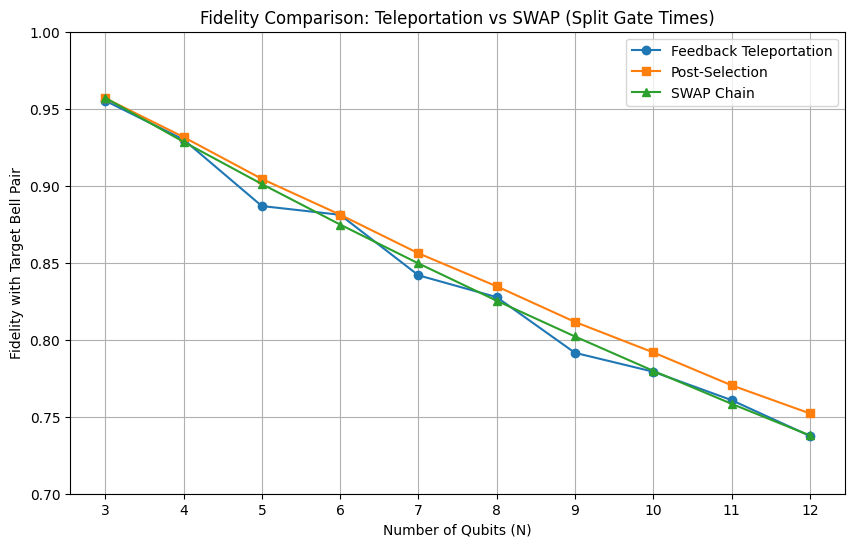

In [8]:
plt.figure(figsize=(10, 6))

plt.plot(N_values, results_feedback, marker='o', label='Feedback Teleportation')
plt.plot(N_values, results_postselect, marker='s', label='Post-Selection')
plt.plot(N_values, results_swap, marker='^', label='SWAP Chain')

plt.title("Fidelity Comparison: Teleportation vs SWAP (Split Gate Times)")
plt.xlabel("Number of Qubits (N)")
plt.ylabel("Fidelity with Target Bell Pair")
plt.legend()
plt.grid(True)
plt.xticks(N_values)
plt.ylim(0.7, 1.0)

plt.show()

--- Feedback Teleportation Circuit (N=5) ---


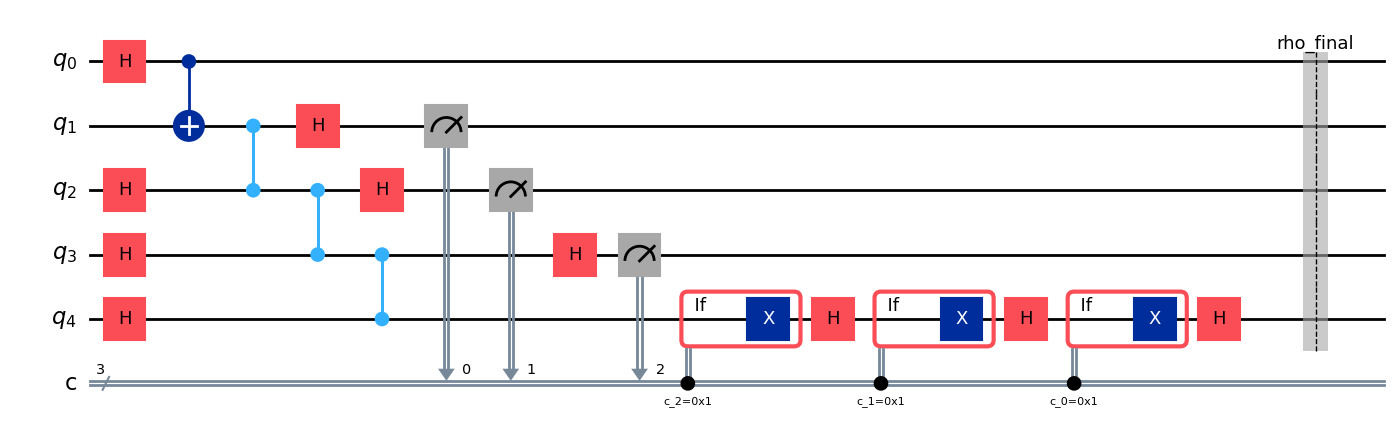


--- Post-Selection Teleportation Circuit (N=5) ---


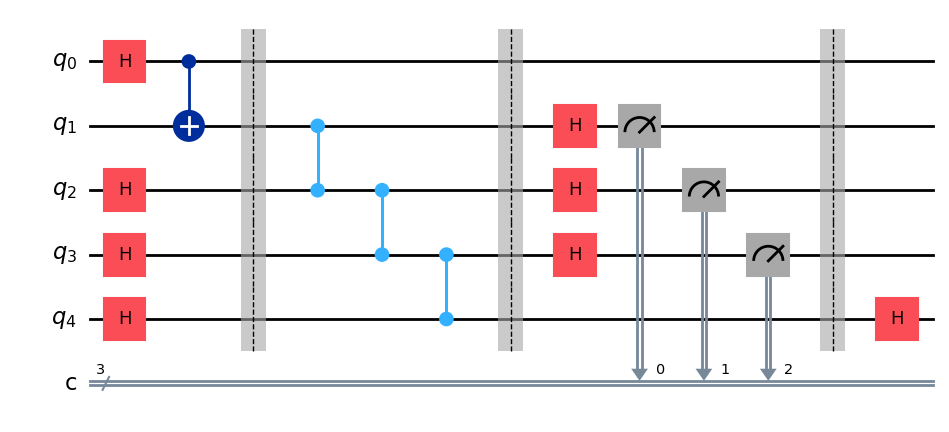


--- SWAP Chain Circuit (N=5) ---


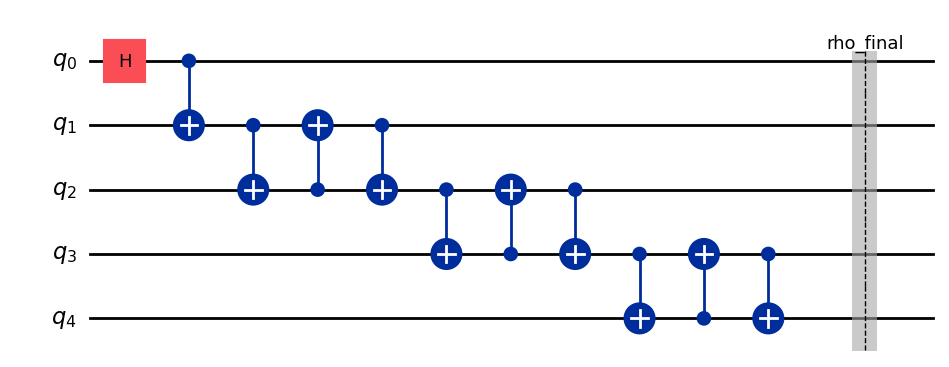

In [9]:
## 7. Circuit Visualizations (N=5)
# This section visualizes the circuit structure for each of the three methods with N=5 qubits.

import matplotlib.pyplot as plt

def draw_circuits_n5():
    n = 5
    
    # 1. Feedback Teleportation Circuit
    print(f"--- Feedback Teleportation Circuit (N={n}) ---")
    circ_feedback = build_feedback_circuit(n)
    display(circ_feedback.draw('mpl'))
    
    # 2. Post-Selection Teleportation Circuit (Conceptual)
    # The simulation code for post-selection evolves density matrices manually. 
    # Here we rebuild the equivalent circuit structure for visualization.
    print(f"\n--- Post-Selection Teleportation Circuit (N={n}) ---")
    circ_post = QuantumCircuit(n, n-2)
    
    # Init
    circ_post.h(0)
    circ_post.cx(0, 1)
    for q in range(2, n):
        circ_post.h(q)
    circ_post.barrier()
    
    # CZ Chain
    for q in range(1, n - 1):
        circ_post.cz(q, q + 1)
    circ_post.barrier()
    
    # Measurement (X basis)
    for idx, q in enumerate(range(1, n - 1)):
        circ_post.h(q)
        circ_post.measure(q, idx)
    circ_post.barrier()
    
    # Structural Corrections (if needed based on N)
    target = n - 1
    num_measurements = n - 2
    if num_measurements % 2 == 1:
        circ_post.h(target)
        
    display(circ_post.draw('mpl'))

    # 3. SWAP Chain Circuit
    print(f"\n--- SWAP Chain Circuit (N={n}) ---")
    circ_swap = build_swap_circuit(n)
    display(circ_swap.draw('mpl'))

draw_circuits_n5()